# Hello Dolby!

My name is Pablo Fernández, I am an Audiovisual Systems Engineering student, and I am applying for the Developer in Entertainment Technology Internship at Dolby Barcelona.

I have prepared this Jupyter notebook as a way of gathering in a single file my audio processing experience during the degree. A lot of the tools used in it were implemented by the Music Technology Group, and can be retrieved from https://github.com/MTG/sms-tools.

To run it, you will need:
- Python 3.*, recommended 3.10
- ipython
- numpy
- matplotlib
- scipy
- cython
- soundfile
- sys
- os

I hope you like it!

In [1]:
import sys
sys.path.append('software/models/')
import numpy as np
import scipy
import soundfile
import matplotlib.pyplot as plt
import IPython.display as ipd
import dftModel as DFT
import utilFunctions as UF
import stft as STFT
import sineModel as SM
import harmonicModel as HM
import hpsModel as HPS


from utilFunctions import wavread
from scipy.io import wavfile
from scipy.signal import get_window

eps = np.finfo(float).eps


## Basics

In this section, we will cover some basics of audio processing, like generating, visualizing and listening to a sine wave.

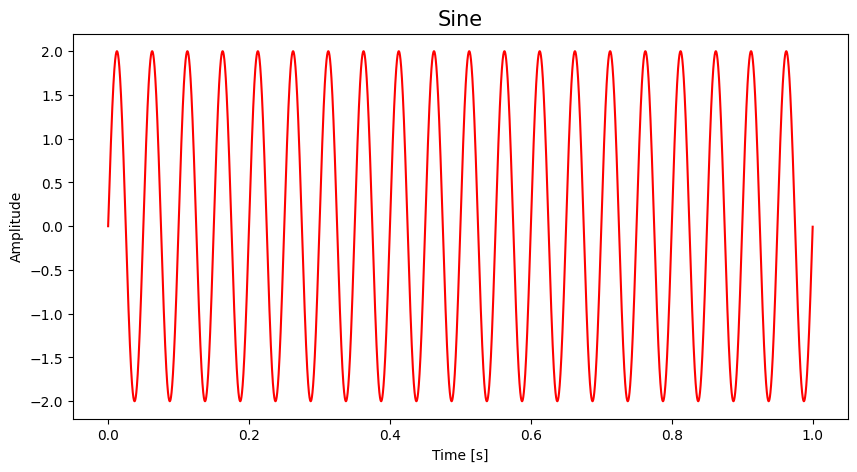

In [2]:
fs = 44100.0 # typical sampling frequency

tt = np.arange(0, 1, 1/fs) # temporal vector, from 0 to 1 in steps of 1/fs seconds.

y = 2 * np.sin(2 * np.pi * 20 * tt) # sinusoid of amplitude 2 and f = 20 Hz

# FIGURE
plt.figure(figsize=(10,5))
plt.plot(tt, y, 'r-')
plt.title("Sine", fontsize=15)
plt.xlabel("Time [s]"), plt.ylabel("Amplitude")
plt.show()

In [3]:
fs = 44100
f = 200
tt = np.arange(0, 2.5, 1/fs)
yy = np.sin(2 * np.pi * f * tt)

soundfile.write('sine50.wav', yy, fs)

ipd.Audio(yy, rate=fs)

## Synthesizing a sound
Now, we will try to approximate a harmonic sound from its frequency components.

In [4]:
def singen(t,f,A,phi):  # Sinusoid generating function

    y = A * np.sin(2*np.pi*f*t + phi)

    return y

In [5]:
x_original = soundfile.read('sounds/sax_baritone_C_sharp.wav')  # Sound to be synthesized.
ipd.Audio(data=x_original[0], rate=48000)

In [6]:
def FFTvisualize(xx, Nfft, fs, title):    # With this function, we will be able to observe the spectral components of a sound
  plt.figure(figsize=(15,5))
  zz = np.abs(np.fft.fft(xx, n=Nfft))
  xf = np.arange(0, fs, fs/float(Nfft))
  plt.plot(xf, zz)
  plt.title(title, fontsize=15)
  plt.xlabel('Frequency (Hz)'), plt.ylabel('Energy')
  plt.xlim(0,fs/2) # For plotting only the first half

  return zz,xf

(0.0, 6000.0)

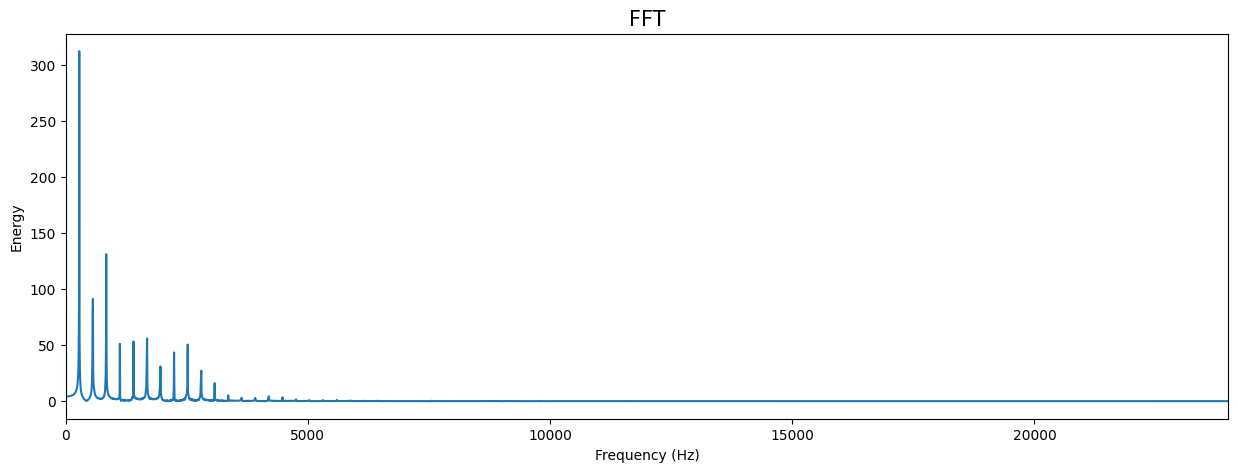

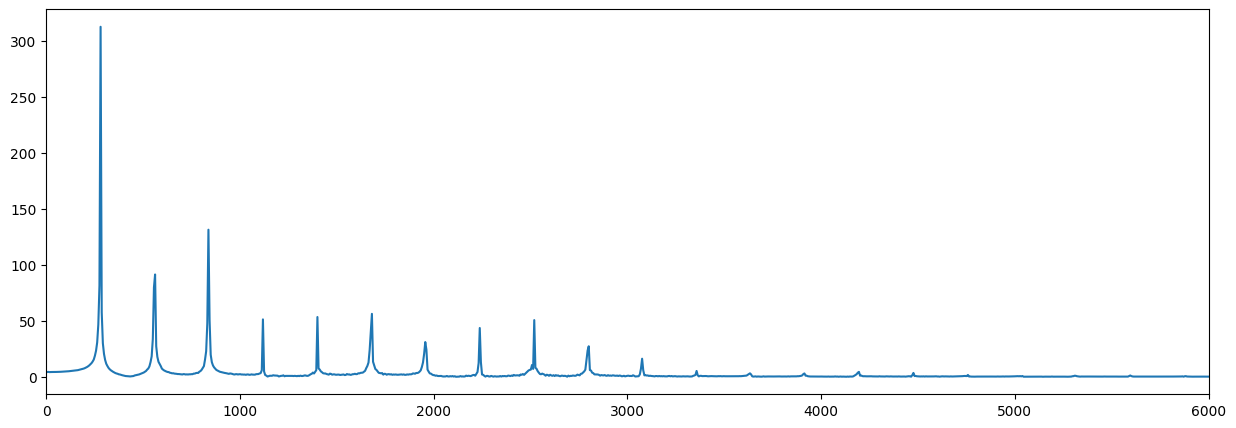

In [7]:
zz,xf = FFTvisualize(x_original[0], Nfft=4096*2, fs=48000, title='FFT')

fig, (p1) = plt.subplots(1, figsize=(15,5))

p1.plot(xf, zz)
p1.set_xlim(00,6000)

In [8]:
def synth(f0,dur):      # Additive synthesis function
  fs = 44100
  phi = 0
  t = np.arange(0,dur,1/fs)

  #0
  A = 0.9
  y = singen(t,f0,A,phi)

  #1
  A = 0.25
  f = 2 * f0
  y += singen(t,f,A,phi)

  #2
  A = 0.4
  f = 3 * f0
  y += singen(t,f,A,phi)

  #3
  A = 0.2
  f = 4 * f0
  y += singen(t,f,A,phi)

  #4
  A = 0.2
  f = 5 * f0
  y += singen(t,f,A,phi)

  #5
  A = 0.2
  f = 6 * f0
  y += singen(t,f,A,phi)

  #6
  A = 0.1
  f = 7 * f0
  y += singen(t,f,A,phi)

  #7
  A = 0.2
  f = 8 * f0
  y += singen(t,f,A,phi)

  #8
  A = 0.2
  f = 9 * f0
  y += singen(t,f,A,phi)

  #9
  A = 0.1
  f = 10 * f0
  y += singen(t,f,A,phi)

  #10
  A = 0.05
  f = 11 * f0
  y += singen(t,f,A,phi)

  #11
  A = 0.025
  f = 12 * f0
  y += singen(t,f,A,phi)

  # Last harmonics (with a similar low amplitude)
  A = 0.0015
  for i in range (13, 21):
    f = i * f0
    y += singen(t,f,A,phi)
  return y

In [9]:
print('Original sound:')
ipd.Audio(data=x_original[0], rate=48000)

Original sound:


In [10]:
x_copy = synth(278.5,2)
print('Synthesised sound:')
ipd.Audio(data=x_copy, rate=44100)

Synthesised sound:


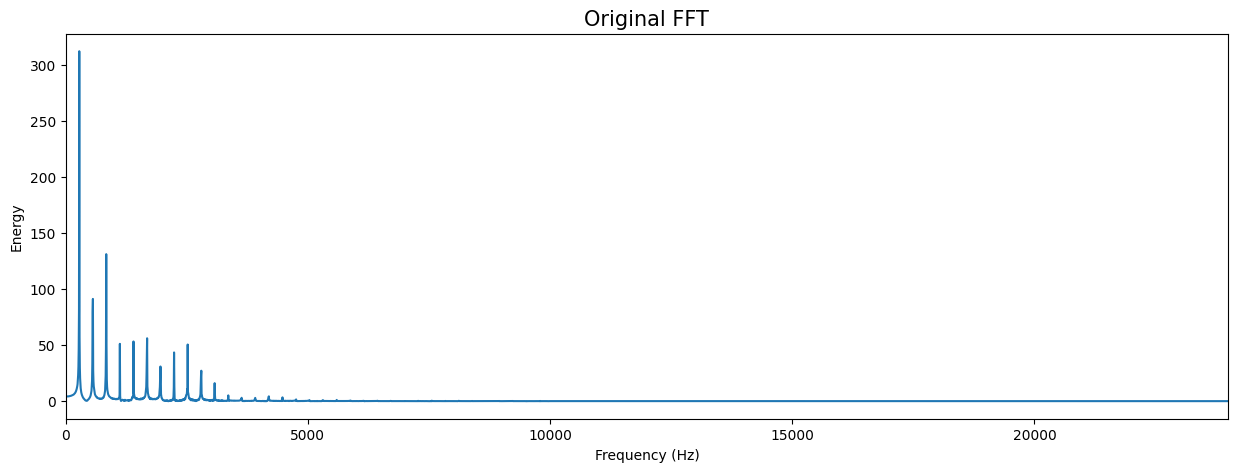

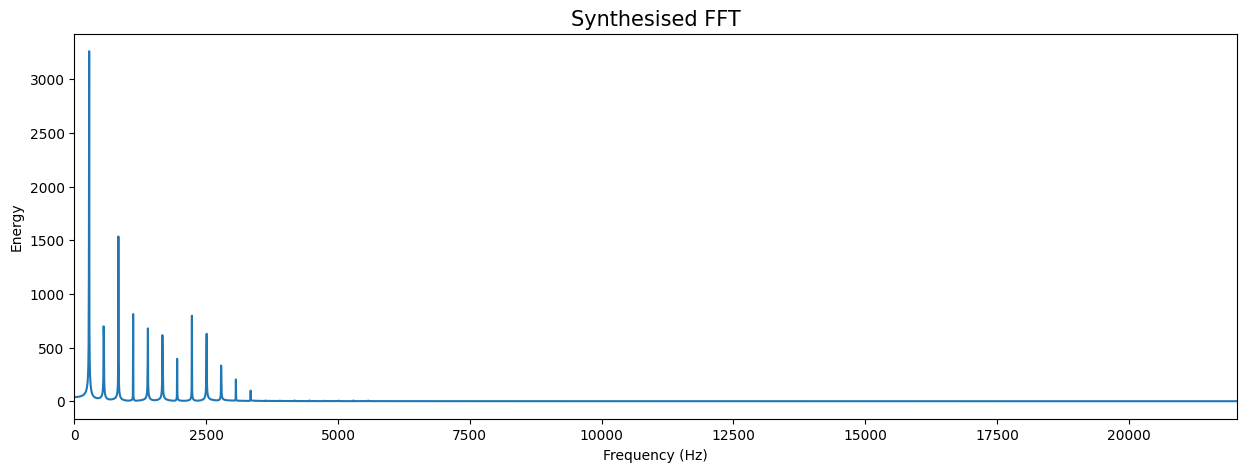

In [11]:
zz,xf = FFTvisualize(x_original[0], Nfft=4096*2, fs=48000, title='Original FFT')
zz2,xf2 = FFTvisualize(x_copy, Nfft=4096*2, fs=44100, title='Synthesised FFT')

That's pretty nice! Let's try to synthesize a melody using the previous function.

In [12]:
x1 = synth(295,0.25)
x2 = synth(590,0.25)
x3 = synth(442,0.25)
x4 = synth(393.8,0.25)
x5 = synth(787.5,0.25)
x6 = synth(743.3,0.25)
x7 = synth(331.1,0.25)

x8 = synth(295,3)
x9 = synth(371.7,3)
x10 = synth(442,3)

x11 = np.concatenate((x1,x2,x3,x4,x5,x3,x6,x3), axis=None)
x22 = np.concatenate((x7,x2,x3,x4,x5,x3,x6,x3), axis=None)
x33 = np.concatenate((x4,x2,x3,x4,x5,x3,x6,x3), axis=None)
x44 = np.concatenate((x1,x2,x3,x4,x5,x3,x8+x9+x10), axis=None)

x_final = np.concatenate((x11,x11,x22,x22,x33,x33,x11,x44), axis=None)

ipd.Audio(data=x_final, rate=44100)

## Downsampling
In this section, we will try to see the effects of downsampling a sound.

In [13]:
def hop_samples(x, M):
    # Return every Mth element of the input array
    
    sel_samples = x[::M]
    return sel_samples

In [14]:
def down_sample_audio(input_file, M):
    # Downsample the input signal by a factor of M
    fs, x = wavread(input_file)
    downsampled_x = hop_samples(x, M)
    new_fs = fs/M

    return (x, fs, downsampled_x, new_fs)

In [15]:
filename1 = "sounds/vibraphone-C6.wav"
M = 14
x1, fs1, y1, new_fs1 = down_sample_audio(filename1, M)

print("Original vibraphone:")
ipd.display(ipd.Audio(data=x1, rate=fs1))

print("Downsampled vibraphone:")
ipd.display(ipd.Audio(data=y1, rate=new_fs1))

print("New fs:", new_fs1)

Original vibraphone:


Downsampled vibraphone:


New fs: 3150.0


In [16]:
filename2 = "sounds/sawtooth-440.wav"
M = 14
x2, fs2, y2, new_fs2 = down_sample_audio(filename2, M)

print("Original sawtooth:")
ipd.display(ipd.Audio(data=x2, rate=fs2))

print("Downsampled sawtooth:")
ipd.display(ipd.Audio(data=y2, rate=new_fs2))

print("New fs:", new_fs2)

Original sawtooth:


Downsampled sawtooth:


New fs: 3150.0


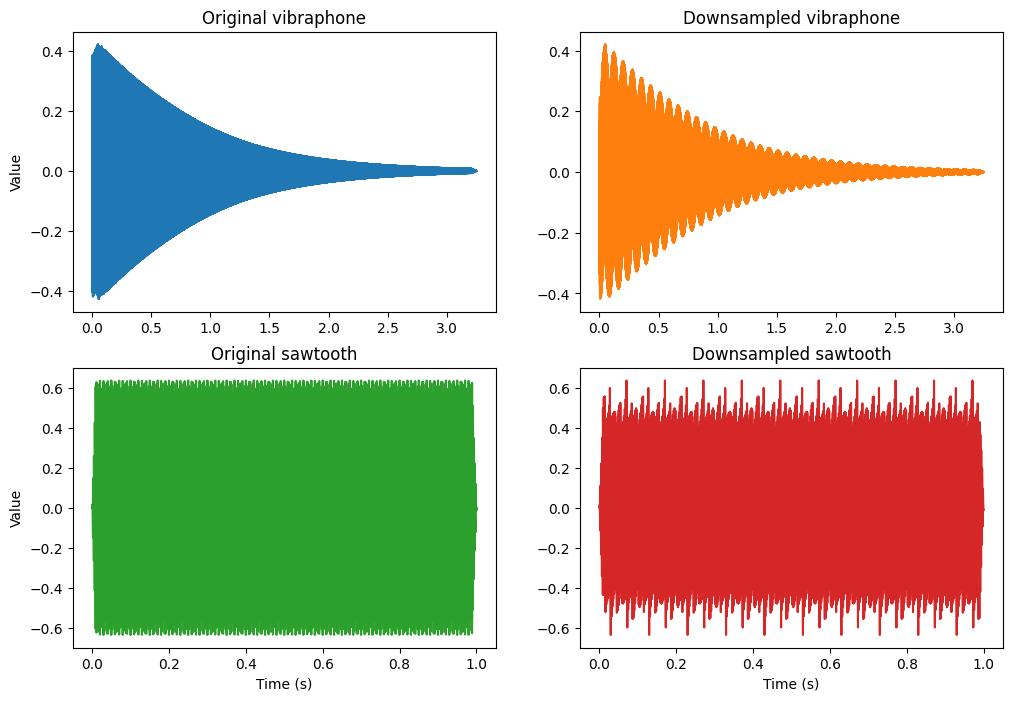

In [17]:
Time1 = np.linspace(0, len(x1) / fs1, num=len(x1))
Time1_ds = np.linspace(0, len(y1) / new_fs1, num=len(y1))
Time2 = np.linspace(0, len(x2) / fs2, num=len(x2))
Time2_ds = np.linspace(0, len(y2) / new_fs2, num=len(y2))

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(Time1, x1)
axs[0, 0].set_title('Original vibraphone')
axs[0, 0,].set(ylabel='Value')
axs[0, 1].plot(Time1_ds, y1, 'tab:orange')
axs[0, 1].set_title('Downsampled vibraphone')
axs[1, 0].plot(Time2, x2, 'tab:green')
axs[1, 0].set_title('Original sawtooth')
axs[1, 0].set(xlabel='Time (s)', ylabel='Value')
axs[1, 1].plot(Time2_ds, y2, 'tab:red')
axs[1, 1].set_title('Downsampled sawtooth')
axs[1, 1].set(xlabel='Time (s)')
plt.show()

In the first case, when we listen to both audios we cannot hear any difference. We can clearly see
in the plot that the signal was downsampled, but since the audio quality was not affected by this we know 
that the applied downsampling function did not damage the signal. 

However, in the second case, there is a significant difference between the input and the ouput signals, 
not only in the plot but also in the audio. The reason for this is called aliasing, a phenomenon that occurs
when the sampling frequency is less than twice the highest frequency contained in the signal, according to
the Nyquist criterion. The fundamental frequency of the sawtooth audio file is 440 (A), and the new sampling
frequency is 3150, meaning that aliasing is happening in harmonics starting from the 3rd one (440x2x2 = 1760,
for which the Nyquist criterion is not satisfied).

The Nyquist criterion is satisfied for the vibraphone downsampling because it is actually a simple sine wave
with a frequency of 1046.50 Hz (C6), and 1046.50x2 < 3150.

A solution for avoiding aliasing without modifying the sampling frequency is the use of anti-aliasing filters.
These filters are Low-Pass Filters applied to the signal before sampling. Their goal is restrict the bandwidth
of a signal so that the aforementioned criterion is satisfied and aliasing is reduced.

## Sinusoidal Model

Let's move to more complex stuff. In this part, we will check the sinusoidal model, which consists of tracking the different sinusoids in a sound.

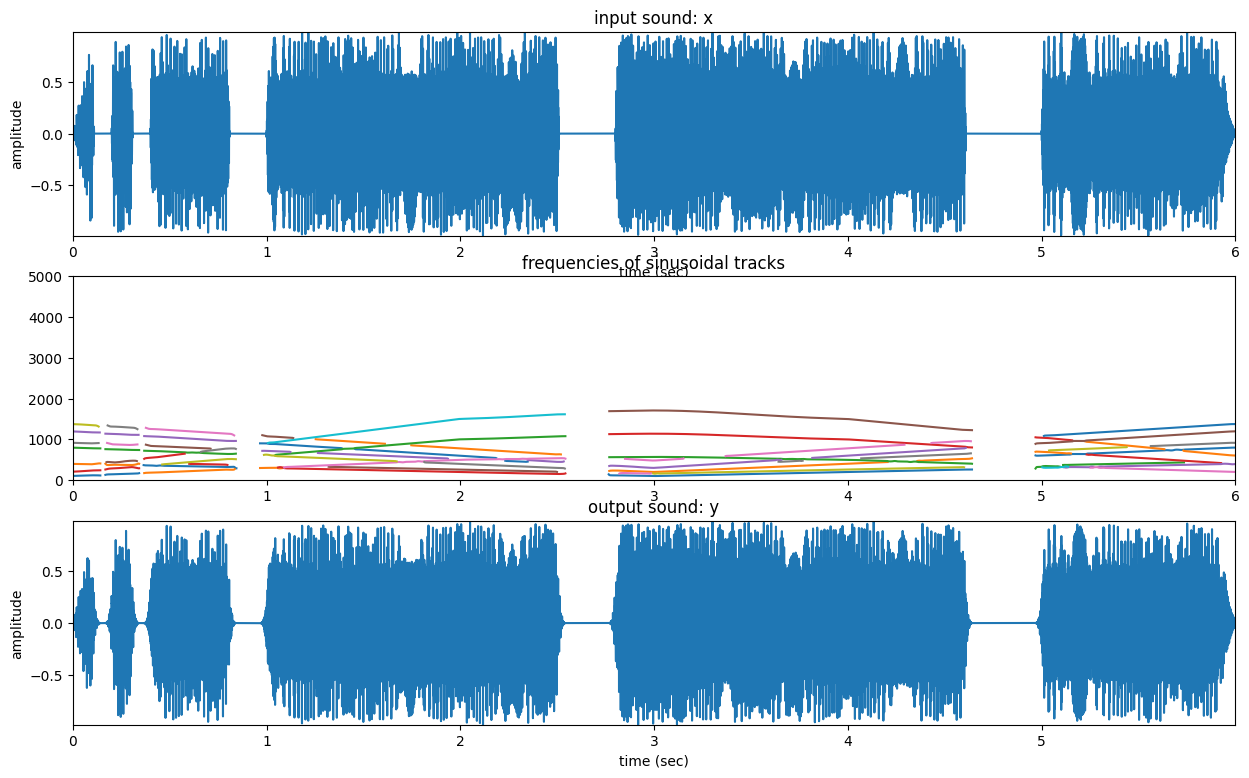

In [18]:
input_file = 'sounds/multiSines.wav'

window = 'blackmanharris'     # Window type                  
M = 4095                      # Window size
N = 4096                      # FFT size
t = -80                       # dB threshold           
minSineDur = 0.1              # Minimum duration of the sinusoids  
maxnSines = 20                # Maximum number of sines 
freqDevOffset = 20            # Allowed deviation for frequency tracking
freqDevSlope = 0.01           # Slope to allow more deviation at higher frequencies 

Ns = 512                                      # size of fft used in synthesis
H = 128                                       # hop size (1/4 of Ns)
    
fs, x = UF.wavread(input_file)               
w = get_window(window, M)                     

# analyze the sound with the sinusoidal model
tfreq, tmag, tphase = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)

# synthesize the output sound from the sinusoidal representation
y = SM.sineModelSynth(tfreq, tmag, tphase, Ns, H, fs)

plt.figure(figsize=(15, 9))
maxplotfreq = 5000.0

# plot the input sound
plt.subplot(3,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')
                
# plot the sinusoidal frequencies
plt.subplot(3,1,2)
if (tfreq.shape[1] > 0):
    numFrames = tfreq.shape[0]
    frmTime = H*np.arange(numFrames)/float(fs)
    tfreq[tfreq<=0] = np.nan
    plt.plot(frmTime, tfreq)
    plt.axis([0, x.size/float(fs), 0, maxplotfreq])
    plt.title('frequencies of sinusoidal tracks')

# plot the output sound
plt.subplot(3,1,3)
plt.plot(np.arange(y.size)/float(fs), y)
plt.axis([0, y.size/float(fs), min(y), max(y)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('output sound: y')

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

In order to recreate the given multi-sinusoidal sound, I used the following parameters:
- Window: Blackman-Harris. The main lobe is quite wide, but the side-lobe level is very low, which is very convenient.
- M: 4095, quite large window size. This has some downsides that are visible on the plot: the attack of the different parts of the sound are not as sharp. However, this allows us to have a greater frequency precision, and it is not noticeable when listening.
- N: 2096, first power of 2 greater than M.
- t: -80 dB. Even though the side-lobe level is at -92 dB, I set the threshold a little higher, just to be safe.
- minSineDur: 0.1, so that the short intervals in the beginning are not lost.
- maxnSines: 20. There are less simultaneous sinusoids, but again, better safe than sorry.
- freqDevOffset: 20, freqDevSlope= 0.01. Default parameters.

Using this values, the two sounds are perceptually identical.

## Harmonic model
Now, we will compute the segmentation of stable frequency regions of an audio signal using the Harmonic Model

In [19]:
def segment_stable_frequency_regions(f0, stdThsld, minNoteDur, winStable):
    
    f0Cents = 1200*np.log2((f0+eps)/55.0)  

    # create an array containing standard deviation of last winStable samples
    stdArr = 10000000000*np.ones(f0.shape)
    for ii in range(winStable-1, len(f0)):
        stdArr[ii] = np.std(f0Cents[ii-winStable+1:ii+1])

    # apply threshold on standard deviation values to find indexes of the stable points in melody
    indFlat = np.where(stdArr<=stdThsld)[0]
    flatArr = np.zeros(f0.shape)
    flatArr[indFlat] = 1

    # create segments of continuous stable points such that consecutive stable points belong to same segment
    onset = np.where((flatArr[1:]-flatArr[:-1])==1)[0]+1
    offset = np.where((flatArr[1:]-flatArr[:-1])==-1)[0] 
    
    # remove any offset before onset (to sync them)
    indRem = np.where(offset<onset[0])[0]              
    offset = np.delete(offset, indRem)
    
    minN = min(onset.size, offset.size)
    segments = np.transpose(np.vstack((onset[:minN], offset[:minN])))

    # apply segment filtering, i.e. remove segments with are < minNoteDur in length
    minNoteSamples = int(np.ceil(minNoteDur*fs/H))
    diff = segments[:,1] - segments[:,0]
    indDel = np.where(diff<minNoteSamples)
    segments = np.delete(segments,indDel, axis=0)

    return segments

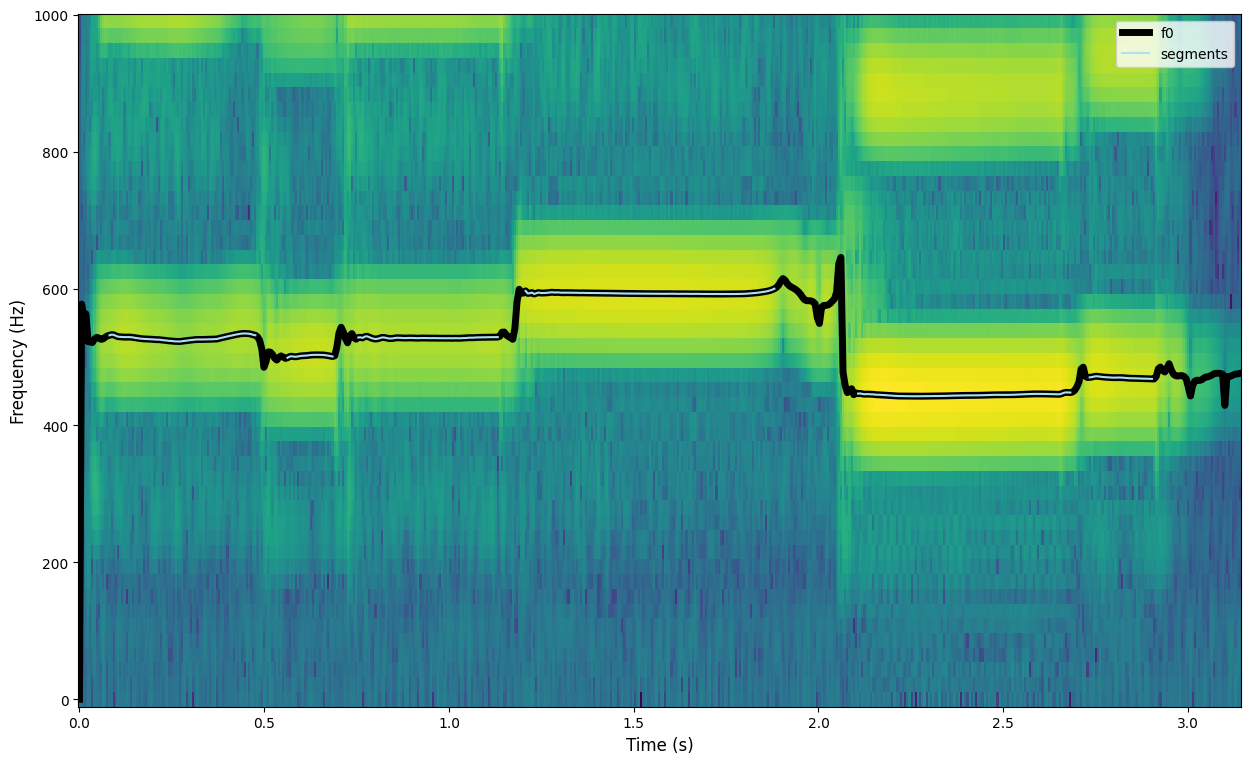

In [20]:
input_file = 'sounds/sax-phrase-short.wav'
stdThsld = 5
minNoteDur = 0.1 
winStable = 3
window = 'blackman'
M = 1025
N = 2048
H = 256
f0et = 10.0
t = -100
minf0 = 420
maxf0 = 650

# compute f0 and segments
fs, x = UF.wavread(input_file) 
w  = get_window(window, M)   
f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)
segments = segment_stable_frequency_regions(f0,stdThsld, minNoteDur,winStable)

y = UF.sinewaveSynth(f0, 0.8, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

# plot spectrogram, f0, and segments
maxplotfreq = 1000.0    

plt.figure(figsize=(15, 9))

mX, pX = STFT.stftAnal(x, w, N, H)
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])
    
timeStamps = np.arange(mX.shape[1])*H/float(fs)                             
binFreqs = np.arange(mX.shape[0])*fs/float(N)
    
plt.pcolormesh(timeStamps, binFreqs, mX, shading='auto')
plt.plot(timeStamps, f0, color = 'k', linewidth=5)

for i in range(segments.shape[0]):
    plt.plot(timeStamps[segments[i,0]:segments[i,1]], f0[segments[i,0]:segments[i,1]], color = '#A9E2F3', linewidth=1.5)        
plt.ylabel('Frequency (Hz)', fontsize = 12)
plt.xlabel('Time (s)', fontsize = 12)
plt.legend(('f0','segments'))
plt.show()

## Sinusoidal plus residual model

Lastly, we will use two models to synthesize speech: the sinusoidal model, which will come handy for the harmonic parts of speech (essentially, the vowels) and the residual model, which will approximate the stochastic component in sounds such as s, t, p, k...

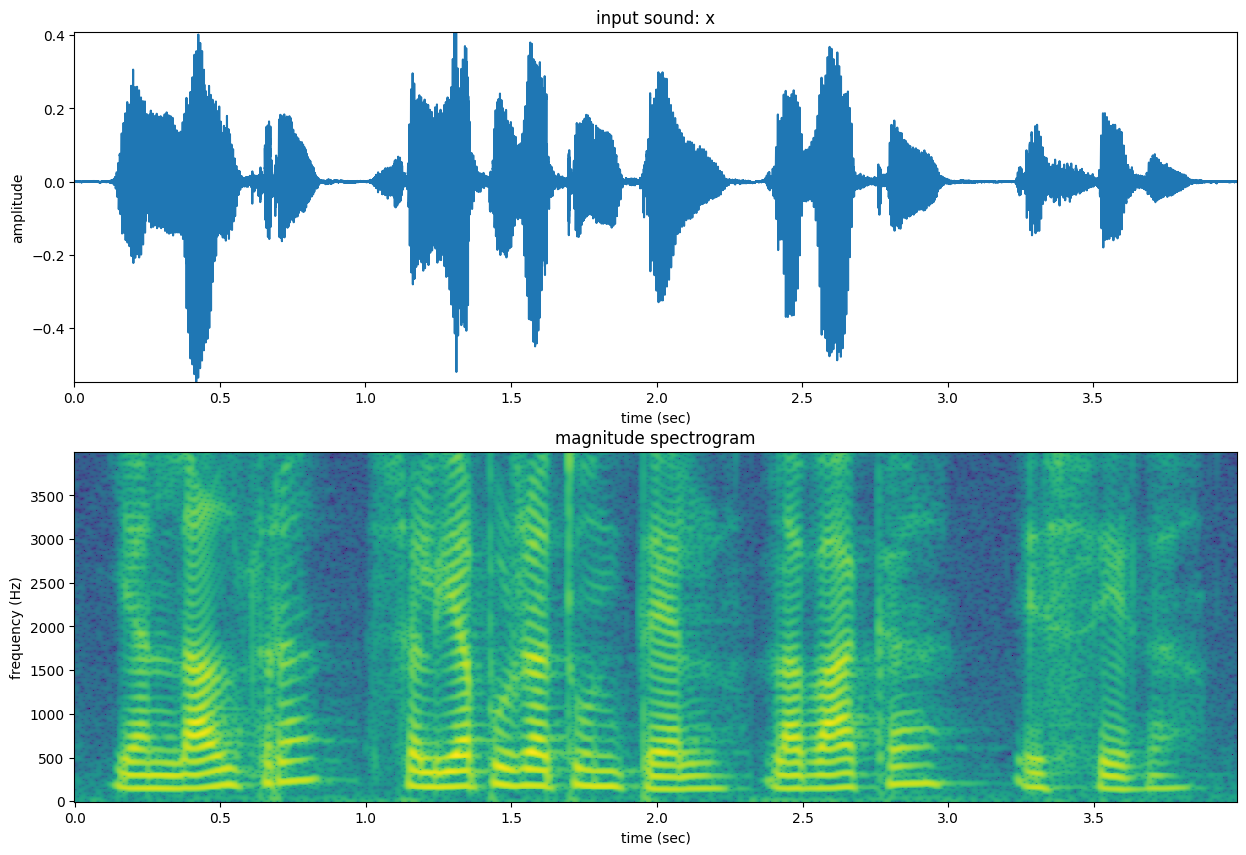

In [21]:
input_file = 'sounds/speech-female.wav'

window = 'blackman'
M = 2243
N = 4096
H = 128

    
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 10))
maxplotfreq = 4000.0

# plot input sound
plt.subplot(2,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

# plot magnitude spectrogram
plt.subplot(2,1,2)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')
plt.show()

In [22]:
input_file = 'sounds/speech-female.wav'

window ='blackman'
M = 2243
N = 4096
t = -57
minSineDur = 0.05
nH = 30
minf0 = 110
maxf0 = 275
f0et = 5
harmDevSlope = 0.01
stocf = 0.3


Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

- Window type: Blackman, because of its good main-lobe width vs side-lobe level trade off.
- FFT size: 4096, large enough to get a good frequency resolution without compromising time resolution.
- Window size: 2243, smaller than the FFT size and large enough to contain the necessary frequency information.
- f0 range: Between 110 and 275, as observed in the spectrogram.
- Error threshold: 5 Hz, small enough to be unnoticeable, but large enough to leave a small margin.
- Number of harmonics: 30, as counted up until 4000 Hz.
- Stochastic decimation factor: 0.3, that is, we are keeping around a third of the original residual magnitude values, since it is not that relevant in the sound.